<font size=5> Social distancing: evidence of privilege in a pandemic from smartphones </font><br>
Nabarun Dasgupta, MPH, PhD | nab@unc.edu | @nabarund<br>
*Dr. Dasgupta is an epidemiologist at the University of North Carolina in Chapel Hill. He studies population level patterns of infectious disease, medication safety, and opioids.*<br>
Thanks to Ben White for data munging help. Code available on [GitHub](https://github.com/opioiddatalab/covid).<br>

**Co-authors**<br>
Michele Jonsson Funk, PhD<br>
Allison Lazard, PhD<br>
Benjamin Eugene White<br>
Steve W. Marshall, PhD<br>

<div class="alert alert-warning">

**Warning:** Code and output provided for evaluation only. Paper under review. Results have not been peer-reviewed and should not be used for clinical or public health interpretation.

</div>

On March 23, 2020 Stuart Thompson and Yaryna Serkez of *The New York Times* [published](https://www.nytimes.com/interactive/2020/03/23/opinion/coronavirus-economy-recession.html) a fascinating use of cell phone GPS signal information to gauge movement and commuting, during the advent of social distancing. They compared the state-level data in a [slick graphic](https://www.nytimes.com/interactive/2020/03/23/opinion/coronavirus-economy-recession.html) to political leanings. But we wanted to understand more about other community level characteristics of slow versus fast adopters.<br>
<br>
We were provided access to the same location dataset on social distancing published today in the. We used a data merging approach we have [previously published](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6339867/). Repurposing code from an ongoing project, we merged in community-level data from the Robert Wood Johnson Foundation's [County Health Rankings](https://www.countyhealthrankings.org/). This very rich dataset contains dozens of explanatory variables about health, social, and economic indicators.<br>

---

In [1]:
display "Notebook generated on $S_DATE at $S_TIME ET"

Notebook generated on 22 Apr 2020 at 16:59:10 ET


# Models

In [40]:
// Load pre-procesed data
clear all
set scheme economist
use "https://github.com/opioiddatalab/covid/blob/master/analysiset.dta?raw=true"

// Create results frame
frame create results str20 strat level avg LL UL

// Program to invert differences
program define invert, rclass
    version 16
    args ee ll ul
    
    di round((1-(1/`ee'))*-100,.1)
    di "LL: " round((1-(1/`ll'))*-100,.1)
    di "UL: " round((1-(1/`ul'))*-100,.1)
end

// Set up negative binomial model
program define modelrun, rclass
    version 16
    syntax varlist(numeric)
    
    frame change default
    foreach var of local varlist {
    
    di "----- RURALITY-ADJUSTED NEGBIN MODEL -----"
       nbreg `var' levels* homeorder i.rucc, irr nocons vce(r)

    * Store results
        frame post results ("`var'") (1) (round((r(table)[1,1]),.1)) (round((r(table)[5,1]),.1)) (round((r(table)[6,1]),.1))
        frame post results ("`var'") (2) (round((r(table)[1,2]),.1)) (round((r(table)[5,2]),.1)) (round((r(table)[6,2]),.1))
        frame post results ("`var'") (3) (round((r(table)[1,3]),.1)) (round((r(table)[5,3]),.1)) (round((r(table)[6,3]),.1))
        frame post results ("`var'") (4) (round((r(table)[1,4]),.1)) (round((r(table)[5,4]),.1)) (round((r(table)[6,4]),.1))
        frame post results ("`var'") (5) (round((r(table)[1,5]),.1)) (round((r(table)[5,5]),.1)) (round((r(table)[6,5]),.1))
        
        di "Compare to tabular data:"
        table iso5, c(count `var' mean `var' sem `var') 

    di "----- PERCENT DIFFERENCE MODEL -----"
    * Rate difference models
        nbreg `var' levels* homeorder i.rucc, irr vce(r)   
           
   * Plot graph
       frame change results
       la var level "Social Distancing: Lowest (1) to Highest (5)"
       line avg level if inlist(strat,"`var'"), title("`var'")

    frame change default
    
    }
end

// Set up scaled Poisson model

program define modelpoisson, rclass
    version 16
    syntax varlist(numeric)
    
    frame change default
    foreach var of local varlist {

    di "----- RURALITY-ADJUSTED POISSON MODEL -----"
       glm `var' levels* homeorder i.rucc, family(poisson) link(log) scale(x2) eform nocons 

    * Store results
        frame post results ("`var'") (1) (round((r(table)[1,1]),.1)) (round((r(table)[5,1]),.1)) (round((r(table)[6,1]),.1))
        frame post results ("`var'") (2) (round((r(table)[1,2]),.1)) (round((r(table)[5,2]),.1)) (round((r(table)[6,2]),.1))
        frame post results ("`var'") (3) (round((r(table)[1,3]),.1)) (round((r(table)[5,3]),.1)) (round((r(table)[6,3]),.1))
        frame post results ("`var'") (4) (round((r(table)[1,4]),.1)) (round((r(table)[5,4]),.1)) (round((r(table)[6,4]),.1))
        frame post results ("`var'") (5) (round((r(table)[1,5]),.1)) (round((r(table)[5,5]),.1)) (round((r(table)[6,5]),.1))
        
        di "Compare to tabular data:"
        table iso5, c(count `var' mean `var' sem `var') 

    di "----- PERCENT DIFFERENCE MODEL -----"
    * Rate difference models
       glm `var' levels* homeorder i.rucc, family(poisson) link(log) scale(x2) eform 
           
   * Plot graph
       frame change results
       la var level "Social Distancing: Lowest (1) to Highest (5)"
       line avg level if inlist(strat,"`var'"), title("`var'")

    frame change default
    
    }
end



---

# Descriptive Results

In [41]:
// Basic distributions of counties and traces
* iso5 is the main outcome variable representing quintiles of mobility change

tab rucc, m
tab iso5, m
table iso5, c(sum last3_sample)
su last3_sample
di "Total 3-day mobile traces: "
    di r(sum)
    
di "Quintile boundaries:"
    gen last3i=last3_index-100
        table iso5, c(min last3i max last3i)
            di "Places with positive movement:"
                tab state if last3i>=0
                table state if last3i>=0, c(median last3i mean rucc)

di "US average change in mobility:"
    qui: su last3_index
        return list
di "US median distance traveled km):"
    qui: su last3_m50, d
        di r(p50)
di "US mean change in mobility"
    qui: su last3_index
        di r(mean)-100
        
di "Mean mobility change by quintile:"
    table iso5, c(count last3_index mean last3_index median last3_index sum samples median last3_m50) 

di "Mean mobility change by status of homeorder:"
    table homeorder, c(count rucc mean last3_index sem last3_index)

di "Rurality/urbanicity by quintile:"
    table iso5, c(median rucc)

di "Small municipalities in highest tier:"
    tab state if rucc>=6 & iso5==5
    
di "Large municipalities in lowest tier:"
    tab state if rucc<=3 & iso5==1



       rucc |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |        426       16.18       16.18
          2 |        368       13.98       30.16
          3 |        336       12.76       42.92
          4 |        214        8.13       51.04
          5 |         92        3.49       54.54
          6 |        572       21.72       76.26
          7 |        387       14.70       90.96
          8 |        124        4.71       95.67
          9 |        114        4.33      100.00
------------+-----------------------------------
      Total |      2,633      100.00


Distancing: |
 Lowest (1) |
 to Highest |
        (5) |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |        519       19.71       19.71
          2 |        526       19.98       39.69
          3 |        513       19.48       59.17
          4 |        540       20.51       79.68
          5 |        535       20.3


----------------------------------------
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       | min(last3_~x)  max(last3_~x)
----------+-----------------------------
        1 |      54.16667            293
        2 |          44.6             54
        3 |      37.66667       44.59375
        4 |      25.16667        37.5942
        5 |             0             25
----------------------------------------


---
# Healthcare

To gauge overall baseline healthcare access and utilization, we examined primary care providers per 100,000 population and percent uninsured under age 65 (e.g., Medicare eligibility). As a marker for a closely related preventive health behavior, we examined whether earlier influenza vaccination rates were associated with how much the county was likely to slow down in the current coronavirus outbreak. This was quantified as the percent of annual Medicare enrollees having an annual influenza vaccination.

## Primary care providers

We wanted to see if places with more social distancing had better healthcare resources. So we looked at primary care providers per 100,000 population. 


----- RURALITY-ADJUSTED NEGBIN MODEL -----
note: you are responsible for interpretation of non-count dep. variable

Fitting Poisson model:

Iteration 0:   log pseudolikelihood = -320092.99  
Iteration 1:   log pseudolikelihood = -48882.026  
Iteration 2:   log pseudolikelihood = -30820.243  
Iteration 3:   log pseudolikelihood =  -26330.47  
Iteration 4:   log pseudolikelihood = -26328.915  
Iteration 5:   log pseudolikelihood = -26328.915  

Fitting full model:

Iteration 0:   log pseudolikelihood = -12906.655  
Iteration 1:   log pseudolikelihood = -12333.437  
Iteration 2:   log pseudolikelihood = -12073.753  
Iteration 3:   log pseudolikelihood = -12073.291  
Iteration 4:   log pseudolikelihood = -12073.291  

Negative binomial regression                    Number of obs     =      2,579
Dispersion           = mean                     Wald chi2(14)     =  158357.87
Log pseudolikelihood = -12073.291               Prob > chi2       =     0.0000

--------------------------------------

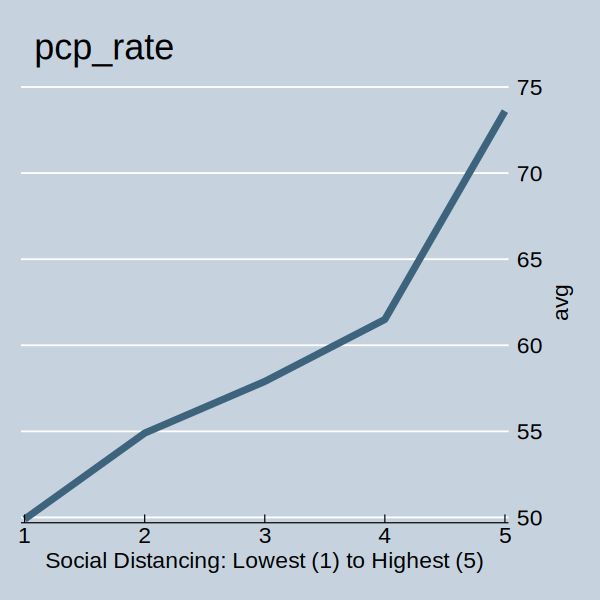

In [4]:
modelrun pcp_rate

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |   48.03302   2.404615    77.34   0.000      43.5439    52.98495
     levels2 |   50.28804   2.545734    77.39   0.000     45.53803    55.53351
     levels3 |   56.80765   2.835276    80.94   0.000     51.51376    62.64558
     levels4 |   61.25371   3.008065    83.79   0.000     55.63286    67.44247
     levels5 |   71.49253   3.509299    86.98   0.000     64.93493    78.71236
`
<br><br>
Percent difference<br> 
`levels1 |   .6718608    .027037    -9.88   0.000     .6209052    .7269981`

In [5]:
invert .6718608 .6209052 .7269981

48.8
LL: 61.1
UL: 37.6



The counties showing the smallest declines in mobility had 48 primary care providers per 100,000, whereas the most social distancing counties had 71 per 100,000 after adjusting for rurality and stay-at-home orders, a 49% (95% CI: 38%, 61%) difference. 

---

## Percent uninsured
Percent of without health insurance below Medicare elgibility (age 65).

----- RURALITY-ADJUSTED POISSON MODEL -----
note: uninsured_p has noninteger values

Iteration 0:   log likelihood = -7726.4116  
Iteration 1:   log likelihood = -7718.2877  
Iteration 2:   log likelihood = -7718.2864  
Iteration 3:   log likelihood = -7718.2864  

Generalized linear models                         Number of obs   =      2,633
Optimization     : ML                             Residual df     =      2,619
                                                  Scale parameter =          1
Deviance         =  4539.377304                   (1/df) Deviance =   1.733248
Pearson          =  4761.738841                   (1/df) Pearson  =   1.818152

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   5.873366
Log likelihood   = -7718.286439                   BIC             =  -16087.55

--------------------------------------------------------------

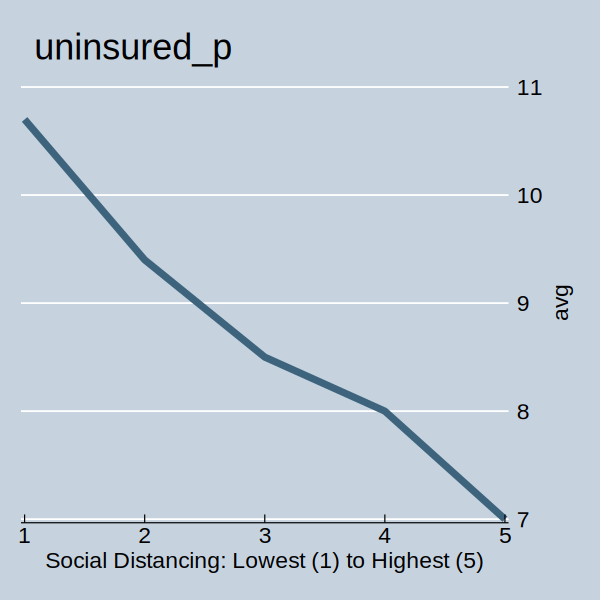

In [6]:
// Comparing percent uninsured to social distancing
modelpoisson uninsured_p 

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |    11.0404   .4479299    59.19   0.000     10.19647    11.95417
     levels2 |    10.5449   .4268925    58.19   0.000      9.74054    11.41568
     levels3 |   9.052178   .3649673    54.64   0.000     8.364388    9.796524
     levels4 |   8.318344   .3368231    52.32   0.000     7.683699    9.005408
     levels5 |   7.144656    .291952    48.12   0.000     6.594755     7.74041
`
<br><br>
Percent difference<br> 
`levels1 |   1.545267   .0467263    14.39   0.000     1.456346    1.639617`

Counties with lower social distancing also had a higher proportion of people without health insurance. The lowest social distancing counties had 11.0% uninsured adults, whereas the most social distancing counties had only 7.1% uninsured after adjusting for rurality and social distancing orders, a 54% (95% CI: 46%, 64%) difference. 

---

## Flu Vaccination

We had a hypothesis that counties that were more involved in preventative behaviors would be more likely to self-isolate more thoroughly. To test this, we examined whether earlier flu vaccination rates impacted how much the county was likely to slow down in the current coronavirus outbreak. This is quantified as the percent of annual Medicare enrollees having an annual flu vaccination, as reported by the Robert Wood Johnson Foundation. Since the flu vaccine is free to all Medicare beneficiaries, and this is the elderly age group with the most influenza mortality, this is a convenient metric to test *a priori* how conscientious the population was, on average.




        % Medicare Beneficiaries Getting Flu Vaccine
-------------------------------------------------------------
      Percentiles      Smallest
 1%           19              9
 5%           26             12
10%           30             12       Obs               2,630
25%           37             13       Sum of Wgt.       2,630

50%           43                      Mean           42.15703
                        Largest       Std. Dev.       8.51741
75%           48             62
90%           52             62       Variance       72.54627
95%           54             63       Skewness      -.6164957
99%           57             65       Kurtosis       3.235287

(bin=10, start=9, width=5.6)


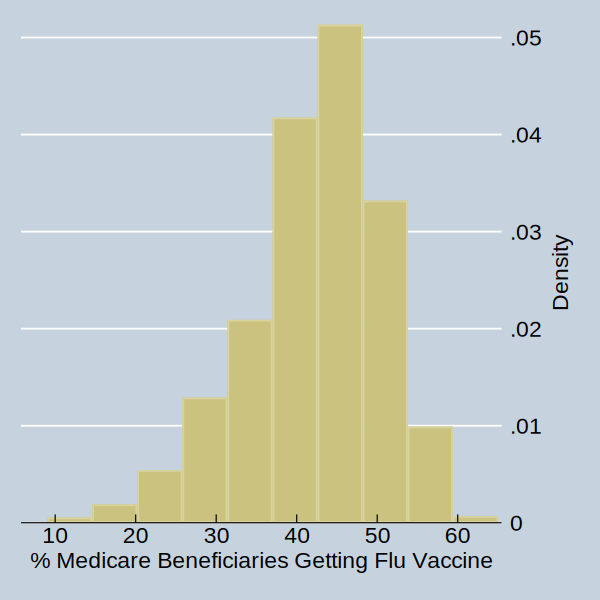

In [7]:
// Basic descriptive on background influenza vaccine
frame change default
summ fluvaccine, d
hist fluvaccine, bin(10)

----- RURALITY-ADJUSTED POISSON MODEL -----

Iteration 0:   log likelihood = -9326.8988  
Iteration 1:   log likelihood = -9325.1183  
Iteration 2:   log likelihood = -9325.1183  

Generalized linear models                         Number of obs   =      2,630
Optimization     : ML                             Residual df     =      2,616
                                                  Scale parameter =          1
Deviance         =  4029.442144                   (1/df) Deviance =   1.540307
Pearson          =  3820.490076                   (1/df) Pearson  =   1.460432

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   7.101991
Log likelihood   = -9325.118318                   BIC             =  -16570.88

------------------------------------------------------------------------------
             |                 OIM
  fluvaccine |        IRR   Std. 

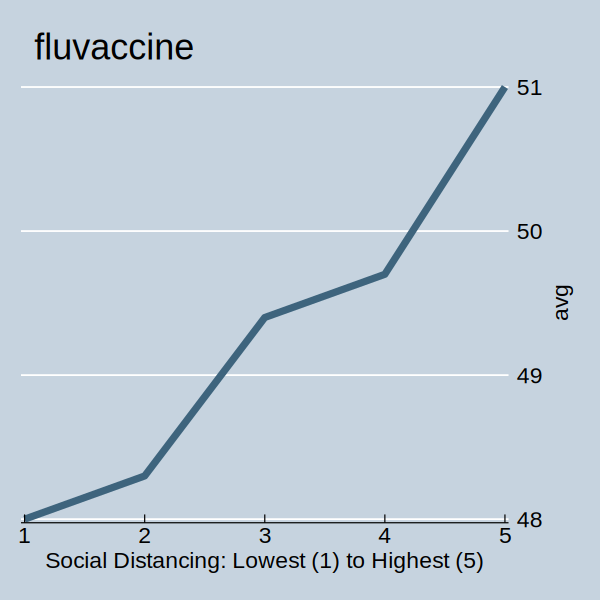

In [8]:
// Comparing background flu vaccination with current social distancing
modelpoisson fluvaccine

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |   48.23875   .8912549   209.80   0.000     46.52317    50.01759
     levels2 |   47.49881   .8681976   211.22   0.000     45.82729    49.23129
     levels3 |   48.55726   .8674856   217.34   0.000     46.88644    50.28762
     levels4 |   49.43355   .8763789   220.02   0.000     47.74538    51.18141
     levels5 |   50.63066   .8872871   223.94   0.000     48.92114    52.39993
`
<br><br>
Percent difference<br> 
`levels1 |   .9527577    .013099    -3.52   0.000      .927427    .9787802`

The lowest social distancing counties had 48.2% flu vaccine coverage among Medicare beneficiaries, whereas the most social distancing counties had 50.6% after adjusting for rurality and social distancing orders, a 5.0% (95% CI: 2.2%, 7.8%) difference. 

In [9]:
invert .9527577 .927427 .9787802

5
LL: 7.8
UL: 2.2


--- 
# Economic

There is a trend emerging. So, since the places with more social distancing seem to have more health resources, perhaps there are trends in financial means? We explored two baseline economic metrics in relation to social distancing, one representing the overall wealth of the community and one proxy for poverty: 80th percentile of annual household income in dollars and the percent of school-age children eligible for subsidized or free lunches.

## Household income

----- RURALITY-ADJUSTED NEGBIN MODEL -----

Fitting Poisson model:

Iteration 0:   log pseudolikelihood = -2.396e+09  
Iteration 1:   log pseudolikelihood = -2.765e+08  (backed up)
Iteration 2:   log pseudolikelihood = -2.287e+08  
Iteration 3:   log pseudolikelihood = -7797007.7  
Iteration 4:   log pseudolikelihood =   -3712358  
Iteration 5:   log pseudolikelihood = -3655049.8  
Iteration 6:   log pseudolikelihood =   -3655041  
Iteration 7:   log pseudolikelihood =   -3655041  

Fitting full model:

Iteration 0:   log pseudolikelihood = -32813.382  
Iteration 1:   log pseudolikelihood = -29141.104  
Iteration 2:   log pseudolikelihood = -29125.526  
Iteration 3:   log pseudolikelihood = -29125.351  
Iteration 4:   log pseudolikelihood = -29125.351  

Negative binomial regression                    Number of obs     =      2,633
Dispersion           = mean                     Wald chi2(14)     =   1.42e+07
Log pseudolikelihood = -29125.351               Prob > chi2       =     0.000

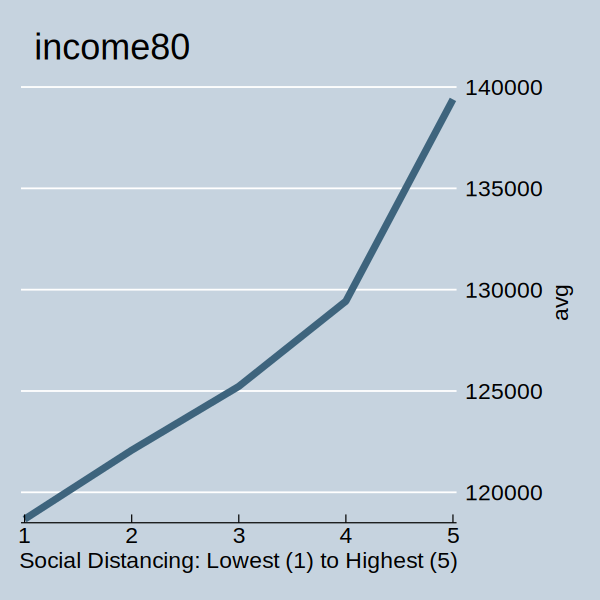

In [10]:
// Comparing 80th percentile income to social distancing
modelrun income80

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |   120492.2   2165.852   650.87   0.000     116321.1    124812.9
     levels2 |     121736   2143.795   664.93   0.000     117605.9    126011.1
     levels3 |   126707.4   2289.893   650.15   0.000     122297.8    131275.9
     levels4 |   132681.5   2399.382   652.28   0.000     128061.2    137468.6
     levels5 |   140242.2    2690.91   617.65   0.000     135066.1    145616.7
`
<br><br>
Percent difference<br> 
`levels1 |   .8591722    .011219   -11.62   0.000     .8374625    .8814448`


The lowest social distancing counties the 80th percentile of annual household income was around `$120,000`, whereas in the most social distancing counties it was `$140,000`, after adjusting for rurality and social distancing orders, a 16% (95% CI: 13%, 19%) difference. 


In [11]:
invert .8591722 .8374625 .8814448

16.4
LL: 19.4
UL: 13.5


---

## Subsidized lunches

----- RURALITY-ADJUSTED NEGBIN MODEL -----
note: you are responsible for interpretation of non-count dep. variable

Fitting Poisson model:

Iteration 0:   log pseudolikelihood = -290091.97  
Iteration 1:   log pseudolikelihood = -36368.036  
Iteration 2:   log pseudolikelihood = -18347.941  
Iteration 3:   log pseudolikelihood =  -13295.81  
Iteration 4:   log pseudolikelihood = -13295.279  
Iteration 5:   log pseudolikelihood = -13295.279  

Fitting full model:

Iteration 0:   log pseudolikelihood = -12572.459  
Iteration 1:   log pseudolikelihood = -11473.257  
Iteration 2:   log pseudolikelihood =  -11337.08  
Iteration 3:   log pseudolikelihood = -10886.708  
Iteration 4:   log pseudolikelihood = -10555.215  
Iteration 5:   log pseudolikelihood = -10531.961  
Iteration 6:   log pseudolikelihood = -10531.538  
Iteration 7:   log pseudolikelihood = -10531.537  

Negative binomial regression                    Number of obs     =      2,520
Dispersion           = mean                 

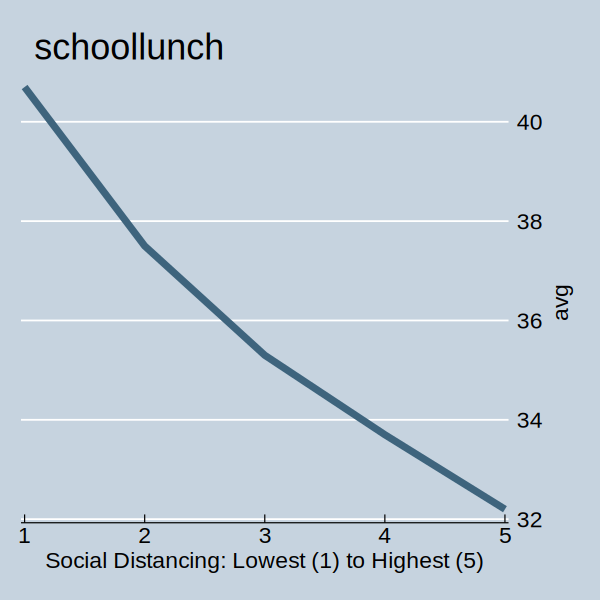

In [12]:
modelrun schoollunch

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |    41.4066   1.367529   112.74   0.000      38.8112    44.17555
     levels2 |   40.94799   1.337411   113.66   0.000     38.40885    43.65499
     levels3 |   37.43485   1.260305   107.60   0.000     35.04443    39.98832
     levels4 |   34.79884   1.160151   106.47   0.000     32.59769    37.14863
     levels5 |   33.23793   1.123619   103.64   0.000     31.10705    35.51478
`
<br><br>
Percent difference<br> 
` levels1 |   1.245763   .0271148    10.10   0.000     1.193737    1.300057`


In the lowest social distancing counties, 41% of schoolage children were eligible for free or reduced price lunches. By comparison, in the most social distancing counties 33% were eligible, after adjusting for rurality and social distancing orders, a 24% (95% CI: 19%, 30%) difference. 


---
# Structural
Three lifestyle metrics were selected to provide a diverse snapshot of baseline structural factors that could influence defiance of prolonged stay-at-home orders. The percent of people experiencing food insecurity was derived from Map the Meal Gap project, based on responses from the Current Population Survey and a cost-of-food index. Access to exercise opportunities was the percent of population with adequate access to locations for physical activity. The percent of households with overcrowding was based on the Comprehensive Housing Affordability Strategy measurements.

## Food insecurity

----- RURALITY-ADJUSTED POISSON MODEL -----
note: foodinsec has noninteger values

Iteration 0:   log likelihood = -7184.3437  
Iteration 1:   log likelihood = -7182.0944  
Iteration 2:   log likelihood = -7182.0943  

Generalized linear models                         Number of obs   =      2,633
Optimization     : ML                             Residual df     =      2,619
                                                  Scale parameter =          1
Deviance         =  2683.121099                   (1/df) Deviance =   1.024483
Pearson          =   2797.25662                   (1/df) Pearson  =   1.068063

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =    5.46608
Log likelihood   = -7182.094311                   BIC             =  -17943.81

------------------------------------------------------------------------------
             |                

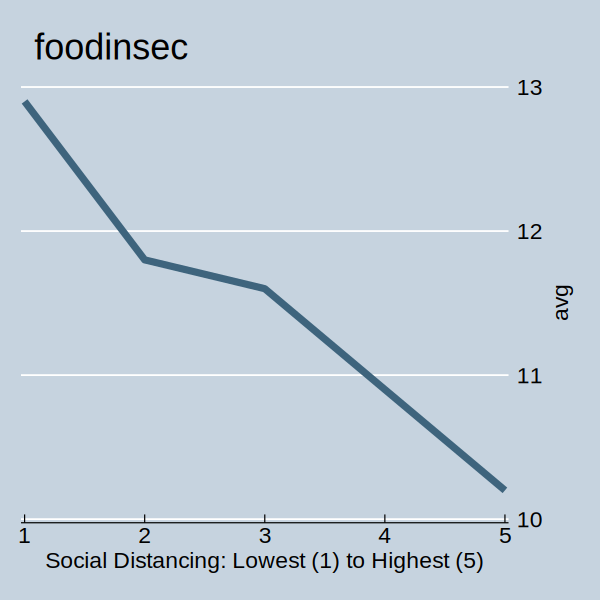

In [13]:
modelpoisson foodinsec

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |   12.98755   .3612017    92.19   0.000     12.29855    13.71514
     levels2 |   12.55802    .348123    91.28   0.000     11.89392     13.2592
     levels3 |   11.60655   .3183067    89.39   0.000     10.99915    12.24749
     levels4 |    11.0192   .3022595    87.48   0.000     10.44242    11.62783
     levels5 |   10.22625   .2805256    84.75   0.000     9.690954    10.79112
`
<br><br>
Percent difference<br> 
`levels1 |    1.27002   .0257634    11.78   0.000     1.220515    1.321533`


The lowest social distancing counties had greater food insecurity, among 13.0% of residents. The most social distancing counties had 10.2%, after adjusting for rurality and social distancing orders, a 27% (95% CI: 22%, 32%) difference. 

---

## Exercise opportunities

----- RURALITY-ADJUSTED NEGBIN MODEL -----
note: you are responsible for interpretation of non-count dep. variable

Fitting Poisson model:

Iteration 0:   log pseudolikelihood = -397571.32  
Iteration 1:   log pseudolikelihood = -24410.221  
Iteration 2:   log pseudolikelihood = -16708.317  
Iteration 3:   log pseudolikelihood = -16405.591  
Iteration 4:   log pseudolikelihood = -16405.296  
Iteration 5:   log pseudolikelihood = -16405.296  

Fitting full model:

Iteration 0:   log pseudolikelihood = -13629.269  
Iteration 1:   log pseudolikelihood = -12618.453  
Iteration 2:   log pseudolikelihood = -12003.767  
Iteration 3:   log pseudolikelihood =  -11968.11  
Iteration 4:   log pseudolikelihood = -11967.878  
Iteration 5:   log pseudolikelihood = -11967.878  

Negative binomial regression                    Number of obs     =      2,633
Dispersion           = mean                     Wald chi2(14)     =  725576.80
Log pseudolikelihood = -11967.878               Prob > chi2       =

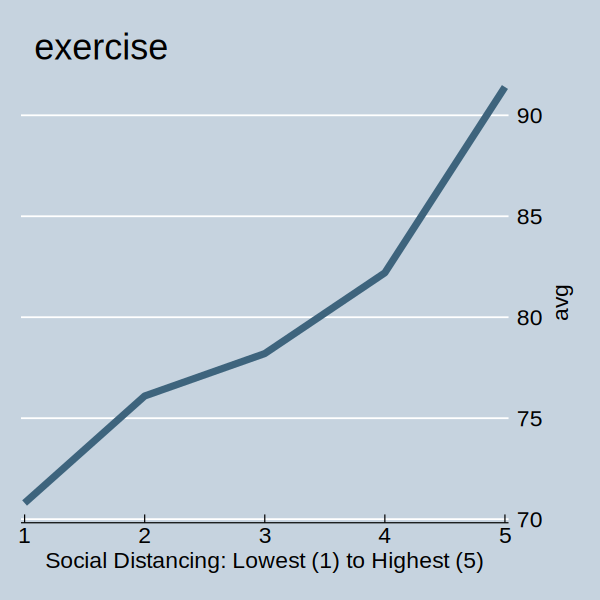

In [14]:
modelrun exercise

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |   68.69511   2.008972   144.63   0.000     64.86832    72.74766
     levels2 |    74.2871   2.075381   154.20   0.000     70.32878    78.46819
     levels3 |   77.96532   2.065593   164.43   0.000     74.02015    82.12077
     levels4 |   82.76289   2.142898   170.55   0.000     78.66768    87.07129
     levels5 |   90.49707   2.206371   184.79   0.000     86.27436    94.92647
`
<br><br>
Percent difference<br> 
`   levels1 |   .7590865   .0177023   -11.82   0.000     .7251717    .7945875`


In the lowest social distancing counties, 69% of residents had access to physical spaces for exercise, whereas in the most social distancing counties 90% had access, after adjusting for rurality and social distancing orders, a 32% (95% CI: 26%, 40%) difference. 

In [15]:
invert .7590865 .7251717 .7945875

31.7
LL: 37.9
UL: 25.9


---

## Overcrowding

----- RURALITY-ADJUSTED POISSON MODEL -----
note: overcrowding has noninteger values

Iteration 0:   log likelihood = -4756.5858  
Iteration 1:   log likelihood = -4744.9748  
Iteration 2:   log likelihood = -4744.9632  
Iteration 3:   log likelihood = -4744.9632  

Generalized linear models                         Number of obs   =      2,633
Optimization     : ML                             Residual df     =      2,619
                                                  Scale parameter =          1
Deviance         =  2650.197886                   (1/df) Deviance =   1.011912
Pearson          =  3524.251156                   (1/df) Pearson  =   1.345648

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =    3.61486
Log likelihood   = -4744.963158                   BIC             =  -17976.73

-------------------------------------------------------------

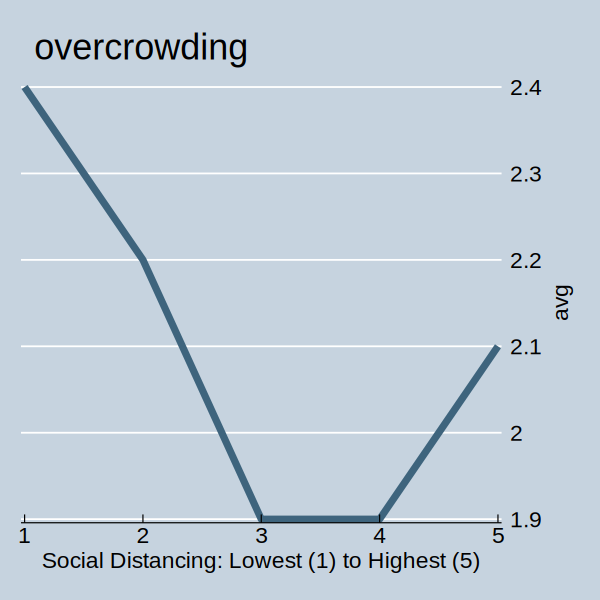

In [16]:
modelpoisson overcrowding

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |   2.340737    .179192    11.11   0.000     2.014605    2.719663
     levels2 |   2.256858   .1718827    10.69   0.000     1.943912    2.620184
     levels3 |   2.106022   .1585213     9.89   0.000     1.817158    2.440806
     levels4 |   2.077067    .155689     9.75   0.000     1.793278    2.405766
     levels5 |   2.010469   .1498266     9.37   0.000     1.737253    2.326653
`
<br><br>
Percent difference<br> 
`     levels1 |   1.164274   .0640694     2.76   0.006     1.045235     1.29687`

The lowest social distancing counties had 16% (95% CI: 4.5%, 30%) less overcrowding, after adjusting for rurality and social distancing orders. 

---
# Sociodemographics

## Youth

Less than age 18

----- RURALITY-ADJUSTED POISSON MODEL -----
note: youth has noninteger values

Iteration 0:   log likelihood = -7047.4698  
Iteration 1:   log likelihood = -7047.2764  
Iteration 2:   log likelihood = -7047.2764  

Generalized linear models                         Number of obs   =      2,633
Optimization     : ML                             Residual df     =      2,619
                                                  Scale parameter =          1
Deviance         =  1084.966828                   (1/df) Deviance =   .4142676
Pearson          =  1091.163655                   (1/df) Pearson  =   .4166337

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   5.363674
Log likelihood   = -7047.276406                   BIC             =  -19541.96

------------------------------------------------------------------------------
             |                 OIM

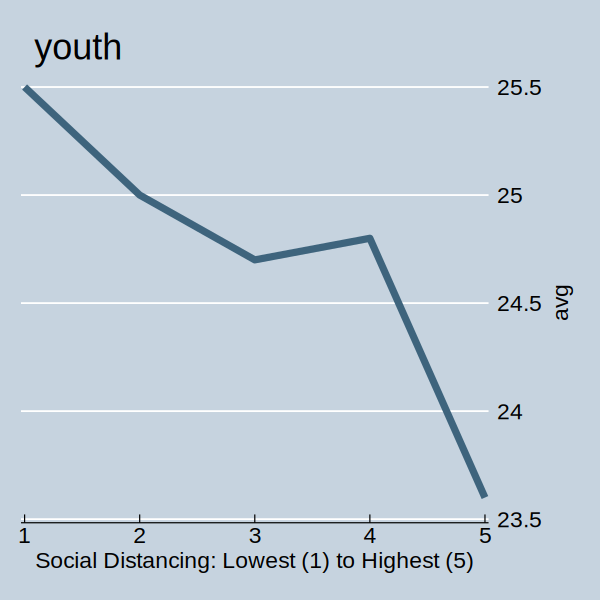

In [17]:
modelpoisson youth

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
     levels1 |   25.34917   .3433241   238.69   0.000     24.68512    26.03108
     levels2 |    25.1898   .3382312   240.29   0.000     24.53552    25.86152
     levels3 |   24.94332    .328453   244.27   0.000      24.3078    25.59546
     levels4 |   24.55284   .3220041   244.06   0.000     23.92977    25.19214
     levels5 |   23.45215   .3067361   241.22   0.000     22.85859    24.06111
`
<br><br>
Percent difference<br> 
`     levels1 |   1.080889   .0110241     7.63   0.000     1.059497    1.102713`

Counties that did not restrict movement 

As the share of the youth popuplation increased 

The lowest social distancing counties had 16% (95% CI: 4.5%, 30%) less overcrowding, after adjusting for rurality and social distancing orders. 

---

## Elderly

### Interpretation

----- RURALITY-ADJUSTED POISSON MODEL -----
note: elderly has noninteger values

Iteration 0:   log likelihood = -7218.0267  
Iteration 1:   log likelihood = -7216.9383  
Iteration 2:   log likelihood = -7216.9383  

Generalized linear models                         Number of obs   =      2,633
Optimization     : ML                             Residual df     =      2,619
                                                  Scale parameter =          1
Deviance         =  2003.292916                   (1/df) Deviance =   .7649076
Pearson          =  2072.529905                   (1/df) Pearson  =    .791344

Variance function: V(u) = u                       [Poisson]
Link function    : g(u) = ln(u)                   [Log]

                                                  AIC             =   5.492547
Log likelihood   = -7216.938253                   BIC             =  -18623.63

------------------------------------------------------------------------------
             |                 O

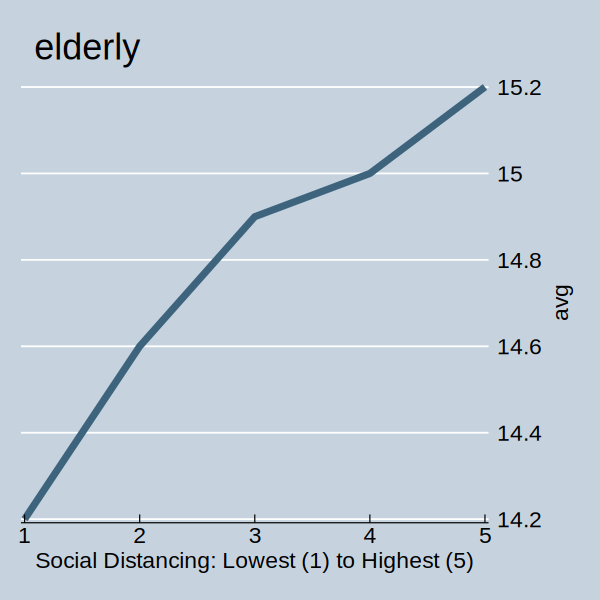

In [18]:
modelpoisson elderly

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
    levels1 |   14.13568   .3077327   121.67   0.000     13.54522    14.75188
     levels2 |   14.34026   .3107842   122.88   0.000     13.74389    14.96251
     levels3 |   14.63441   .3106594   126.41   0.000     14.03802    15.25613
     levels4 |   14.94357   .3143969   128.54   0.000      14.3399    15.57266
     levels5 |    15.1625   .3164327   130.28   0.000     14.55482    15.79556
`
<br><br>
Percent difference<br> 
`     levels1 |   .9322789   .0144558    -4.52   0.000     .9043722    .9610467`

The lowest social distancing counties had 16% (95% CI: 4.5%, 30%) less overcrowding, after adjusting for rurality and social distancing orders. 

In [19]:
invert .9322789 .9043722 .9610467

7.3
LL: 10.6
UL: 4.1


---

## Segregation

### Interpretation

----- RURALITY-ADJUSTED NEGBIN MODEL -----
note: you are responsible for interpretation of non-count dep. variable

Fitting Poisson model:

Iteration 0:   log pseudolikelihood = -137517.44  
Iteration 1:   log pseudolikelihood = -14752.896  
Iteration 2:   log pseudolikelihood = -13227.944  
Iteration 3:   log pseudolikelihood = -13227.003  
Iteration 4:   log pseudolikelihood = -13227.003  

Fitting full model:

Iteration 0:   log pseudolikelihood = -11513.071  
Iteration 1:   log pseudolikelihood = -10469.271  
Iteration 2:   log pseudolikelihood =  -10203.36  
Iteration 3:   log pseudolikelihood =  -10195.34  
Iteration 4:   log pseudolikelihood = -10195.337  
Iteration 5:   log pseudolikelihood = -10195.337  

Negative binomial regression                    Number of obs     =      2,581
Dispersion           = mean                     Wald chi2(14)     =  216209.08
Log pseudolikelihood = -10195.337               Prob > chi2       =     0.0000

--------------------------------------

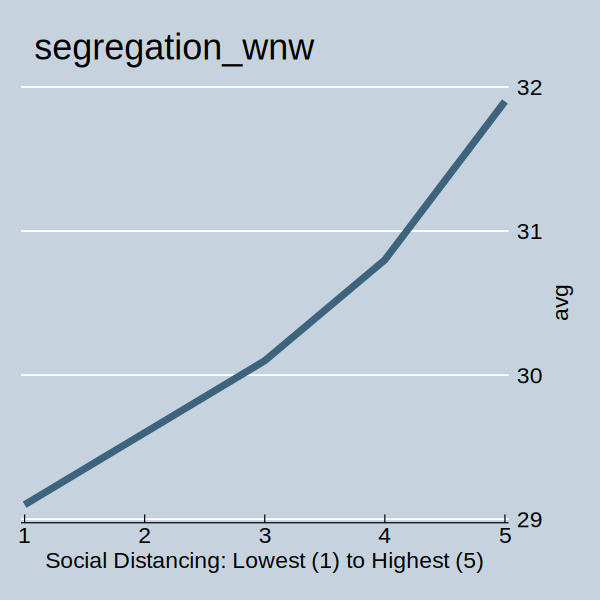

In [20]:
modelrun segregation_wnw

### Interpretation
<br><br>

Relative effect measures <br>
`    ^
      levels1 |   28.47816   1.219824    78.19   0.000     26.18495    30.97219
      levels2 |   28.01057   1.171094    79.71   0.000     25.80679    30.40253
      levels3 |   29.37394   1.228875    80.80   0.000     27.06149    31.88399
      levels4 |   29.15434   1.174793    83.70   0.000     26.94037    31.55026
      levels5 |   31.81989   1.253444    87.84   0.000     29.45562    34.37392
`
<br><br>
Percent difference<br> 
`     levels1 |   .8949799   .0268652    -3.70   0.000      .843844    .9492145`

The lowest social distancing counties had 16% (95% CI: 4.5%, 30%) less overcrowding, after adjusting for rurality and social distancing orders. 

In [21]:
invert .8949799 .843844 .9492145

11.7
LL: 18.5
UL: 5.4


---

# Exploratory analyses




----------------------------------------------------------
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(drivea~p)  mean(drivea~p)   sem(drivea~p)
----------+-----------------------------------------------
        1 |            519       82.089322        .2316678
        2 |            526       81.973571        .1901521
        3 |            513       81.401447        .1971413
        4 |            540        80.95994        .1918464
        5 |            535       77.732723        .3661999
----------------------------------------------------------


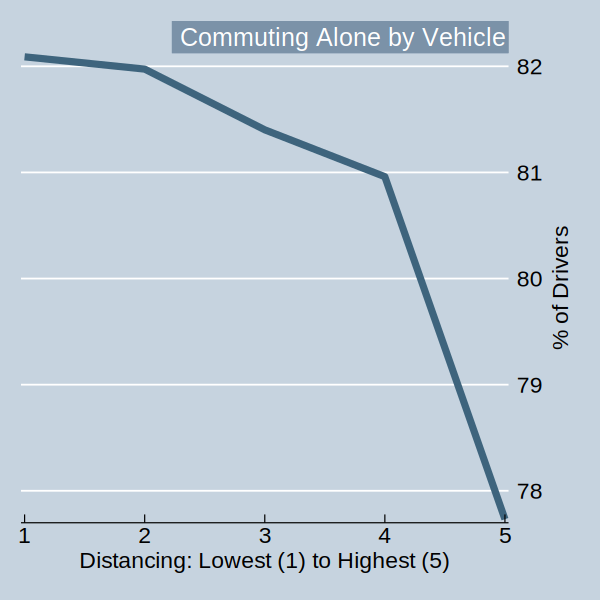

In [22]:
frame change default
foreach var of varlist drivealone_p {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Drivers"
                        line `var' iso5, note("Commuting Alone by Vehicle")  
                            frame change default
                                frame drop `var'
}

---





----------------------------------------------
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(rucc)  mean(rucc)   sem(rucc)
----------+-----------------------------------
        1 |        519   5.2524085    .0987557
        2 |        526     4.63308    .1022326
        3 |        513    4.594542    .1055764
        4 |        540    4.062963     .104029
        5 |        535   3.6093459    .1101034
----------------------------------------------


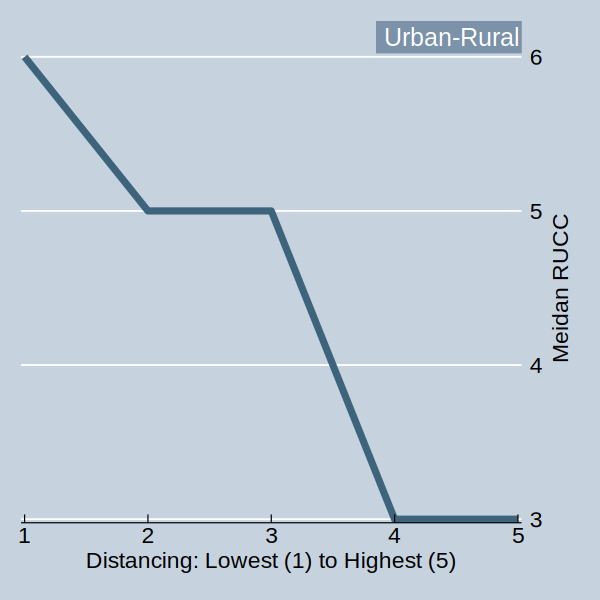

In [23]:
frame change default
foreach var of varlist rucc {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (median) `var', by(iso5)
                    la var `var' "Meidan RUCC"
                        line `var' iso5, note("Urban-Rural")   
                            frame change default
                                frame drop `var'
}




----------------------------------------------------------
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(longco~p)  mean(longco~p)   sem(longco~p)
----------+-----------------------------------------------
        1 |            519       29.061464        .5501718
        2 |            526       31.741635         .530849
        3 |            513       32.373489         .503766
        4 |            540       32.046667        .5223995
        5 |            535        33.41215         .499872
----------------------------------------------------------


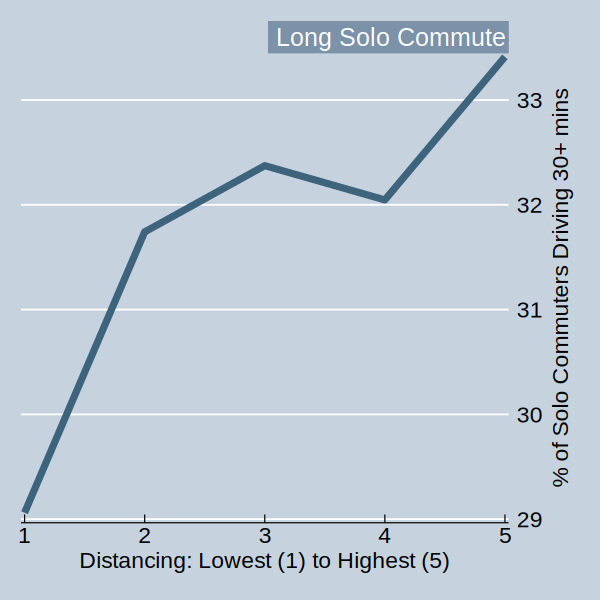

In [24]:
frame change default
foreach var of varlist longcommute_p {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Solo Commuters Driving 30+ mins"
                        line `var' iso5, note("Long Solo Commute")     
                            frame change default
                                frame drop `var'
}

---

# External validation with Google data

Correlations between March 1 to April 11 in Google and DL data by county-day

In [25]:
// Import Descartes Labs data
clear
import delimited "https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv", encoding(ISO-8859-9) stringcols(6) 

    di "Drop state aggregates:"
        drop if admin2==""
    di "Drop improbable outliers (n=490 or <0.4% of observations N=130,685):"
        drop if m50_index>200

    * Format date
        gen date2=date(date,"YMD")
            format date2 %td
                drop date
                    rename date2 date

    * Note data start and end dates for graphs
        su date 
            local latest: disp %td r(max)
                di "`latest'"
            local earliest: disp %td r(min)
                di "`earliest'"

    * Rename variables for consistency
        rename admin1 state
        rename admin2 county


save dl_x_valid, replace

// Process Google app check-in data
clear
import delimited "/Users/nabarun/Documents/GitHub/covid/fips-google-mobility-daily-as-of-04-20-20.csv", stringcols(1) numericcols(5 6 8)  

    * Format date
        gen date=date(report_date, "YMD")
            format date %td
                order date, first
                    drop report_date

    * Note data start and end dates for graphs
        su date 
            local latest: disp %td r(max)
                di "Latest: " "`latest'"
            local earliest: disp %td r(min)
                di "Earliest: " "`earliest'"

    save google_x_valid, replace
    

// Merge by date and county, retain
    merge 1:1 date fips using dl_x_valid

    tab _merge
        keep if _merge==3
            drop _merge country_code admin_level

    * Variable cleanup
    destring retail_and_recreation_percent_ch grocery_and_pharmacy_percent_cha workplaces_percent_change_from_b, replace force
    rename retail_and_recreation_percent_ch retailrec
    rename grocery_and_pharmacy_percent_cha grocery
    rename workplaces_percent_change_from_b work
    rename residential_percent_change_from_ home
    rename parks_percent_change_from_baseli parks
        la var parks "Parks"
    rename transit_stations_percent_change_ transit
                la var transit "Transit"
    
    gen m50i = m50_index-100
            la var m50i "Re-centered at zero"

    * Correlation matrix on complete case data (n=20,891)
    correlate m50i retailrec grocery work home parks transit
        matrix C = r(C)
     
    * Pairwise correlations
    correlate m50i retailrec
    correlate m50i grocery
    correlate m50i work
    correlate m50i home
    correlate m50i parks
    correlate m50i transit

frame change default



(9 vars, 133,285 obs)

Drop state aggregates:

(2,600 observations deleted)

Drop improbable outliers (n=490 or <0.4% of observations N=130,685):

(490 observations deleted)






    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        date |    130,195    21999.54    14.42399      21975      22024


19apr2020


01mar2020



file dl_x_valid.dta saved


(8 vars, 152,039 obs)






    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        date |    152,039     21988.1    16.42271      21960      22016


Latest: 11apr2020


Earliest: 15feb2020

file google_x_valid.dta saved


    Result                           # of obs.
    -----------------------------------------
    not matched                        70,280
        from master                    46,062  (_merge==1)
        from using            

---

*fin.*